In [1]:
import tensorflow as tf
import os
import zipfile


DESIRED_ACCURACY = 0.999

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip" \
    -O "/tmp/happy-or-sad.zip"

zip_ref = zipfile.ZipFile("/tmp/happy-or-sad.zip", 'r')
zip_ref.extractall("/tmp/h-or-s")
zip_ref.close()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>DESIRED_ACCURACY):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

--2021-05-10 10:11:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.02s   

2021-05-10 10:11:07 (103 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



In [2]:
# Directory with our happy pictures
happy_dir = os.path.join('/tmp/h-or-s/happy')

# Directory with our sad pictures
sad_dir = os.path.join('/tmp/h-or-s/sad')

In [3]:

train_happy = os.listdir(happy_dir)
print(train_happy[:10])

train_sad = os.listdir(sad_dir)
print(train_sad[:10])

['happy1-16.png', 'happy1-08.png', 'happy1-05.png', 'happy2-19.png', 'happy1-19.png', 'happy2-07.png', 'happy1-11.png', 'happy2-06.png', 'happy1-07.png', 'happy1-06.png']
['sad1-14.png', 'sad2-13.png', 'sad2-17.png', 'sad2-12.png', 'sad1-05.png', 'sad1-10.png', 'sad1-13.png', 'sad2-07.png', 'sad1-19.png', 'sad1-07.png']


In [4]:
print('total training happy images:', len(os.listdir(happy_dir)))
print('total training sad images:', len(os.listdir(sad_dir)))


total training happy images: 40
total training sad images: 40


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

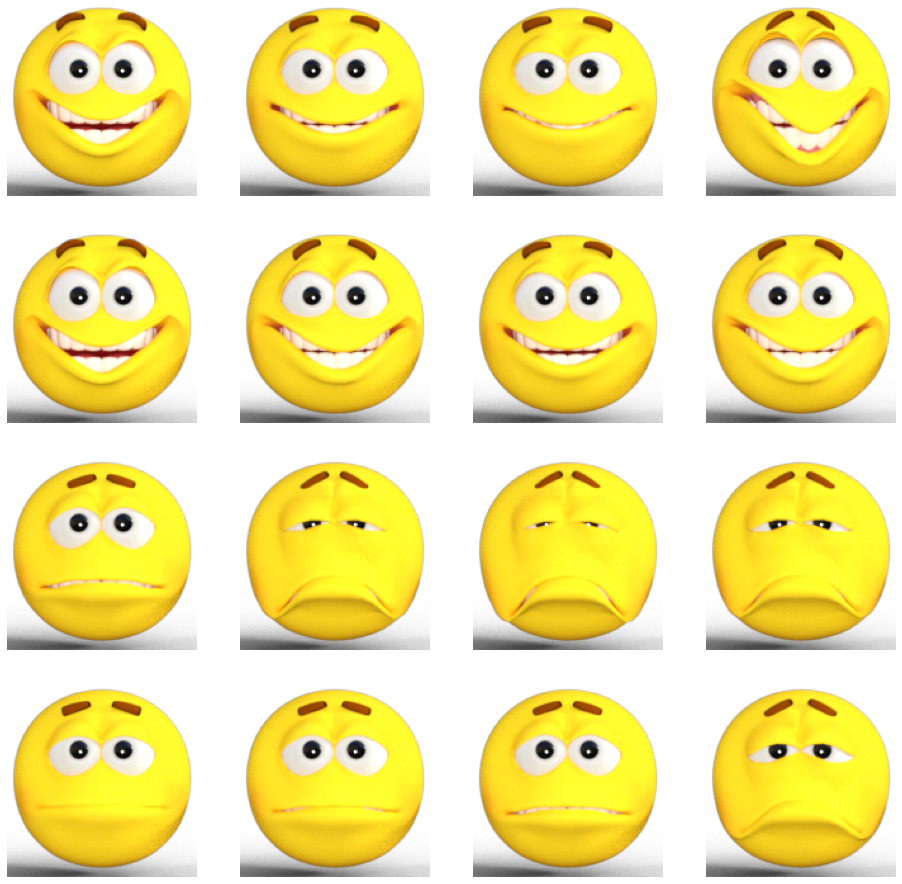

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_happy_pix = [os.path.join(happy_dir, fname) 
                for fname in train_happy[pic_index-8:pic_index]]
next_sad_pix = [os.path.join(sad_dir, fname) 
                for fname in train_sad[pic_index-8:pic_index]]

for i, img_path in enumerate(next_happy_pix+next_sad_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:

# This Code Block should Define and Compile the Model
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0

In [9]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [10]:
# This code block should create an instance of an ImageDataGenerator called train_datagen 
# And a train_generator by calling train_datagen.flow_from_directory

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen =  ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        '/tmp/h-or-s/',  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Expected output: 'Found 80 images belonging to 2 classes'

Found 80 images belonging to 2 classes.


In [11]:
# This code block should call model.fit_generator and train for
# a number of epochs. 
history = model.fit_generator(
      train_generator,
      steps_per_epoch=16,  
      epochs=15,
      verbose=1,callbacks=[callbacks])
      # Your Code Here)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
16/16 [==============================] - 4s 41ms/step - loss: 0.7254 - acc: 0.4512


In [15]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a happy")
  else:
    print(fn + " is a sad")

Saving smiley-vector-happy-face-260nw-465566966.jpg to smiley-vector-happy-face-260nw-465566966.jpg
[0.]
smiley-vector-happy-face-260nw-465566966.jpg is a sad


In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)